# A Basic Example of Topic Modeling

This is an example of how to perform topic modeling.

There are several hyperparameters for the algorithms. There are two different topic modeling algorithms implemented in this example, non-negative matrix factorization (NMF) and Latent Dirichlet Allocation (LDA).

In [1]:
# Necessary for importing modules from a sub-directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if os.getcwd().split('/')[-1] == 'notebook_examples':
    os.chdir(r"../")


# Importing libraries
import pandas_gbq
import pickle
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models, corpora
from src.efselabwrapper.pipeline import run_processing_pipeline
from src.utils.read_txt import txtdir_tolist

## Data Settings
This is where the parameters are set for choosing which articles to perform topic modeling with.

The number of articles needs to big enough to make the statistical relationships between the words reliable, hence giving meaningful topics. For advanced analysis we recommend this to be bigger than 5000, preferably around 10 000. To preprocess 10 000 articles takes about 1.5-2 minutes (which is the most time-consuming part of the modeling).

In [2]:
PREPROCESSED = True

if PREPROCESSED:
    pickle_filename = 'data/preprocessed/sou-2020-2021.text_NOUN_PROPN.pickle'
    preprocessed_corpus = pickle.load(open(pickle_filename, 'rb'))
    
else:
    # tags to choose:
    # ['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV', 'SCONJ', 'AUX', 'PUNCT', 'ADP', 'PRON','DET', 'PART', 'CCONJ', 'NUM', 'INTJ']
    pos_tags = ['NOUN', 'PROPN']
    
    # Specify directory of .txt files to load them all into a list of strings for preprocessing,
    # or load in your own data format, but transform it into (list of string) before preprocessing
    txtfile_dirname = ''
    txtfile_filename = 'data/sou-2020-2021.text'
    raw_corpus = txtdir_tolist(txtfile_filename)
    
    # Preprocess
    preprocessed_corpus = run_processing_pipeline(raw_corpus, pos_tags)

## Model Settings
This is where parameters for the modeling are chosen.
Part of Speech Tags (pos_tags) represents which Part of Speach classes are used in the modeling. In this example, all classes except nouns are filtered out.

The number of topics can be chosen as well as which algorithm to use. Which algorithm to use is highly use case dependent, hence there is no general best algorithm. A throughout comparison between the two algorithms can be found in our thesis (link in README), but as a short summary one can say that NMF is faster and creates more specific topics while LDA is slower and create more general and comprehensive topics.

In [3]:
# Choose algorithm, LDA or NMF
algorithm = 'NMF' #'NMF' | 'LDA'

# Number of topics
NUM_TOPICS = 40

# NMF settings
NMF_NORM = 'frobenius' # ‘frobenius’ | ‘kullback-leibler’ | ‘itakura-saito’
NMF_SOLVER = 'mu' # ‘cd’ | ‘mu’
INIT = None # None | ‘random’ | ‘nndsvd’ | ‘nndsvda’ | ‘nndsvdar’ | ‘custom’
ALPHA = 0 # float

## Build Topic Model

In [6]:
if algorithm == 'LDA':
    # Set mallet path
    mallet_path ='src/mallet/bin/mallet'
    
    # Format Gensim components for data
    id2word = corpora.Dictionary(preprocessed_corpus)
    id2word.filter_extremes(no_below=2)
    corpus = [id2word.doc2bow(text) for text in preprocessed_corpus]

    # Train model
    model = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus,
                                      id2word=id2word,
                                      num_topics=NUM_TOPICS)
    topics = model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)
    
    doc_topic_weights = np.array([[e[1] for e in doc] for doc in model[corpus]])

    
if algorithm == 'NMF':
    # Create TF-IDF
    vectorizer = TfidfVectorizer(
        lowercase=False,
        tokenizer=lambda x: x,
        max_df=0.95,
        min_df=2,
        max_features=None,
        use_idf=True
    )
    tf_idf = vectorizer.fit_transform(preprocessed_corpus)
    feature_names = vectorizer.get_feature_names()
    
    # Train model
    model = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)

    W = model.fit_transform(tf_idf, y=feature_names)
    H = model.components_   

    def get_NMF_topics(model, feature_names, n_top_words):
        all_topics = []
        for topic_idx, topic in enumerate(model.components_):
            sumtopic = np.sum(topic)
            topic_formatted = (topic_idx, [(feature_names[i], topic[i]/sumtopic) for i in topic.argsort()[:-n_top_words - 1:-1]])
            all_topics.append(topic_formatted)
        return all_topics

    topics = get_NMF_topics(model, feature_names, 10)
    doc_topic_weights = W

doc_topic = [np.argmax(e) for e in doc_topic_weights]
topic_counts = [doc_topic.count(i) for i in range(len(topics))]


## Print Topics

T1: ml leverans mervärdesskatt mervärdesskattedirektiv nml transaktion förvärv skatteverk företrädaransvar återbetalning 
T2: gymnasieskola statsbidrag yrkesutbildning dimensionering komvux skolverk kommunutredning samverkansområde landsbygdskommun boende 
T3: arbetslöshetskassa arbetslöshetsförsäkring arbetslöshetsersättning alf inkomstvillkor ersättningsperiod dataanalys ramtid företagare kassa 
T4: marknadskontroll sanktionsavgift miljöbalk sektorslagstiftning eeg unionslagstiftning eut tillverkare kontrollmyndighet gärning 
T5: textil avfall plast producentansvar producent engångsartikel insamlingssystem mugg förpackning livsmedelsbehållare 
T6: al historia ojämlikhet arkiv boende jämlikhet förälder integration utställning oecd 
T7: sfi komvux vuxenutbildning lärare kurs undervisning skolverk andraspråk lärande lärosäte 
T8: omsorgskontakt patient socialstyrelse välfärdsteknik hemtjänst samtycke äldreomsorg kunskapsstyrning vårdgivare antalsberäkning 
T9: hav vattenmyndighet miljöm

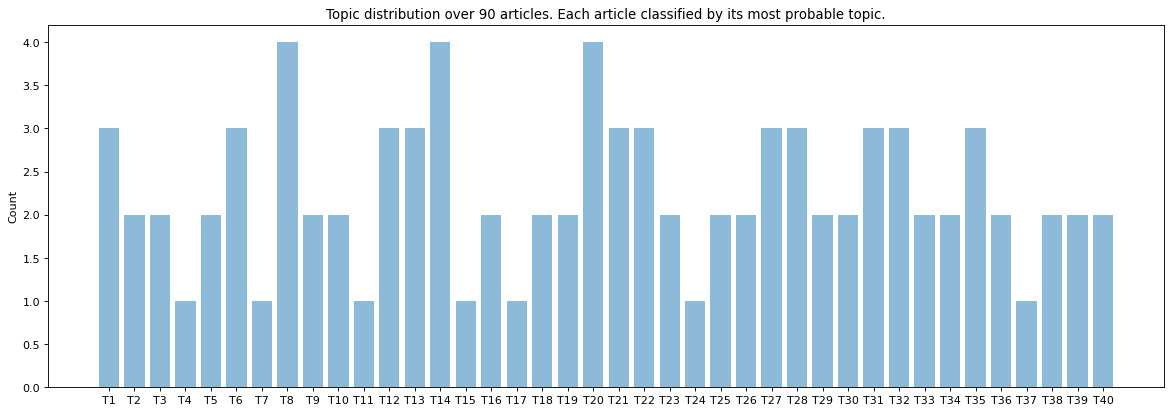

In [7]:
for topic in topics:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts)} articles. Each article classified by its most probable topic.')
plt.show()

In [8]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    
if algorithm == 'NMF':
    W_norm = W / W.sum(axis=1)[:, None]
    H_smooth = np.add(H, 0.000000000001)
    H_norm = H_smooth / H_smooth.sum(axis=1)[:, None]
    term_freq = tf_idf.sum(axis=0).getA1()
    doc_len = tf_idf.sum(axis=1).getA1()

    opts = {'vocab': feature_names, 
            'doc_lengths': doc_len.tolist(),
            'term_frequency': term_freq.tolist(),
            'doc_topic_dists': W_norm.tolist(),
            'topic_term_dists': H_norm.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model, corpus, id2word, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts)

/Users/johan.blad/opt/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/johan.blad/opt/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/johan.blad/opt/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.086728 -0.030746       1        1  2.715433
1     -0.230854 -0.069565       2        1  3.458038
2      0.022127  0.051643       3        1  2.584449
3      0.190752  0.035298       4        1  1.317761
4      0.092119 -0.179179       5        1  2.720446
5     -0.136868 -0.002352       6        1  3.752822
6     -0.286753 -0.034645       7        1  1.929267
7     -0.097100  0.067370       8        1  2.759491
8      0.101650 -0.244264       9        1  5.593445
9     -0.048293  0.052617      10        1  2.391913
10    -0.283330 -0.043517      11        1  2.253125
11    -0.048949 -0.034207      12        1  2.009844
12    -0.043559  0.023123      13        1  2.123314
13     0.084700 -0.222915      14        1  6.279696
14     0.146674  0.180286      15        1  1.592183
15     0.150078  0.132956      16        1  2.586479
16     0.179187  0.063285      17        1  1.137412
17     0.022338  0.005205      18        1  1.298082
18     0.173516  0.021510      19        1  2.423279
19    -0.291245  0.001394      20        1  4.169243
20     0.013343 -0.099682      21        1  1.860249
21    -0.066369 -0.077617      22        1  2.680593
22     0.111074  0.053837      23        1  1.219767
23    -0.025739  0.009239      24        1  5.864577
24     0.047712 -0.142458      25        1  1.344678
25     0.024507  0.011008      26        1  1.494917
26    -0.052457  0.040701      27        1  1.470266
27     0.091408  0.106848      28        1  2.336355
28     0.100775 -0.246921      29        1  5.596914
29     0.007570 -0.051111      30        1  1.216611
30    -0.055727  0.198462      31        1  3.039297
31     0.106442  0.157719      32        1  2.639676
32    -0.011407  0.006888      33        1  0.773534
33     0.058274 -0.219932      34        1  1.709219
34    -0.060678 -0.012090      35        1  1.512445
35     0.097092  0.002513      36        1  2.157351
36     0.002713  0.226470      37        1  2.489463
37    -0.099006  0.020860      38        1  1.435314
38    -0.090617  0.170578      39        1  2.339685
39     0.018169  0.071391      40        1  1.723366, topic_info=              Term         Freq        Total Category  logprob  loglift
1401          skog  5403.000000  5403.000000  Default  30.0000  30.0000
1809      åklagare  3008.000000  3008.000000  Default  29.0000  29.0000
7441           hav  4509.000000  4509.000000  Default  28.0000  28.0000
18689           ml  2626.000000  2626.000000  Default  27.0000  27.0000
914         lärare  3792.000000  3792.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
4123          ljud    89.930394   175.313006  Topic40  -5.4071   3.3934
3655        förlag    92.961756   204.066815  Topic40  -5.3740   3.2746
7572   kommunallag   120.244010   475.937725  Topic40  -5.1166   2.6851
3644    författare   102.055840   280.689737  Topic40  -5.2806   3.0492
5877           lov    87.909486   260.928085  Topic40  -5.4298   2.9730

[3531 rows x 6 columns], token_table=       Topic      Freq                                               Term
term                                                                     
3027      24  0.989603  .................................................
27548     38  1.003615  .................................................
38025     23  0.995105                                            a)efter
30447     35  0.995276                                            absence
3046      24  0.989603                                           achieved
...      ...       ...                                                ...
5355      23  0.040159                                             övning
5355      24  0.040159                                             övning
5355      27  0.658604                                             övning
5355      38  0